# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
%pip install hf_xet
%pip install yfinance

In [9]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf

import os
from google.colab import drive
drive.mount('/content/drive')

from sentence_transformers import CrossEncoder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
DIR = "/content/drive/MyDrive/Colab Notebooks/Fintech/Pt4/"
os.chdir(DIR)

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [7]:
df_news = pd.read_csv('data/df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [8]:
df_meta = pd.read_csv('data/df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [10]:
# CODE HERE
# Use as many coding cells as you need

model = CrossEncoder('cross-encoder/nli-deberta-v3-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [11]:
positive_pairs = [("This news headline suggests a positive sentiment.", title) for title in df_news['TITLE']]
negative_pairs = [("This news headline suggests a negative sentiment.", title) for title in df_news['TITLE']]

In [12]:
positive_scores = model.predict(positive_pairs, apply_softmax=True)
negative_scores = model.predict(negative_pairs, apply_softmax=True)

df_news['POSITIVE_PROB'] = [score[2] for score in positive_scores]
df_news['NEGATIVE_PROB'] = [score[2] for score in negative_scores]

df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']

df_news[['TITLE', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']].head()

,TITLE,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,2 Dow Jones Stocks with Promising Prospects an...,0.993473,0.964023,0.029450
1,3 S&P 500 Stocks Skating on Thin Ice,0.000784,0.000269,0.000515
2,3M Rises 15.8% YTD: Should You Buy the Stock N...,0.999167,0.460373,0.538794
3,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,0.976810,0.265103,0.711707
4,3 Cash-Producing Stocks with Questionable Fund...,0.000612,0.998080,-0.997468


In [13]:
df_news[['TITLE', 'POSITIVE_PROB', 'NEGATIVE_PROB', 'SENTIMENT']].head(15) # add this second df to see a bigger output in order to avoid executing the last cell

,TITLE,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,2 Dow Jones Stocks with Promising Prospects an...,0.993473,0.964023,0.029450
1,3 S&P 500 Stocks Skating on Thin Ice,0.000784,0.000269,0.000515
2,3M Rises 15.8% YTD: Should You Buy the Stock N...,0.999167,0.460373,0.538794
3,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,0.976810,0.265103,0.711707
4,3 Cash-Producing Stocks with Questionable Fund...,0.000612,0.998080,-0.997468
5,Here's Why You Should Retain 3M Stock in Your ...,0.999186,0.005995,0.993191
6,"3M Co: A company with a sound balance sheet, a...",0.998268,0.000888,0.997380
7,"Rogers, Enviri, 3M, Gates Industrial Corporati...",0.988074,0.000730,0.987344
8,"3 ""Top Picks"" From Wall Street That Are Magnif...",0.997604,0.001275,0.996329
9,3M vs. Honeywell: Which Industrial Conglomerat...,0.996022,0.993623,0.002399


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [22]:
# CODE HERE
# Use as many coding cells as you need

df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE'])
daily_sentiment = df_news.groupby('PUBLICATION_DATE')['SENTIMENT'].mean().reset_index()
daily_sentiment.columns = ['DATE', 'AVG_SENTIMENT']
display(daily_sentiment.head())

,DATE,AVG_SENTIMENT
0,2024-07-12,-0.009325
1,2024-07-22,0.045296
2,2024-08-19,0.749797
3,2024-09-13,0.887978
4,2024-10-26,0.998387


In [23]:
tickers = df_news['TICKER'].unique().tolist()
tickers.append("^GSPC")

data = yf.download(tickers,
                   start="2025-01-01",
                   end="2025-08-01",
                   group_by="ticker",
                   auto_adjust=True)

if isinstance(data.columns, pd.MultiIndex):
    price_data = data.xs('Close', axis=1, level=1)
else:
    price_data = data

price_data.head()

[*********************100%***********************]  488 of 488 completed


Ticker,PTC,EXPE,LVS,WFC,JKHY,AON,SPGI,KMX,HPE,ALGN,...,MLM,BKNG,MPC,CRL,CBRE,GDDY,KLAC,ABBV,XEL,APH
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-02,183.009995,184.500702,49.050869,69.058388,171.856094,352.849274,493.689240,81.220001,21.143349,208.490005,...,508.989746,4906.750488,139.887833,182.639999,129.899994,198.910004,633.659790,174.627640,65.217506,68.710068
2025-01-03,184.539993,185.257294,49.562019,70.160332,172.581406,351.855286,497.744354,80.070000,21.488024,208.259995,...,515.080933,4885.391113,141.123672,185.800003,131.500000,200.389999,653.954956,176.359894,65.051682,69.795334
2025-01-06,184.830002,184.162216,50.063339,70.868713,168.537613,346.378357,492.384003,79.750000,22.502354,218.880005,...,515.778809,4891.308594,138.938690,189.539993,132.389999,199.339996,687.090149,175.269928,64.066200,70.820847
2025-01-07,183.089996,181.514114,48.657677,70.435799,170.236588,346.348511,489.554413,79.120003,21.941027,217.559998,...,507.085602,4778.046875,140.055893,189.759995,128.639999,195.570007,686.094788,174.715210,64.557953,71.149422
2025-01-08,184.360001,181.802826,48.313633,70.416138,172.333008,350.334473,494.047913,81.930000,21.694832,215.369995,...,515.659180,4854.079102,140.718307,187.910004,129.779999,197.139999,683.009277,173.712845,65.295593,71.517815


In [24]:
returns = price_data.pct_change().dropna()
returns['AVG_RETURN'] = returns.drop(columns=['^GSPC'], errors='ignore').mean(axis=1)

if '^GSPC' in returns.columns:
    returns_final = returns[['AVG_RETURN', '^GSPC']].reset_index()
    returns_final.columns = ['DATE', 'AVG_RETURN', 'SP500_RETURN']
else:
    returns_final = returns[['AVG_RETURN']].reset_index()
    returns_final.columns = ['DATE', 'AVG_RETURN']

/tmp/ipython-input-3381120088.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_data.pct_change().dropna()
/tmp/ipython-input-3381120088.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  returns['AVG_RETURN'] = returns.drop(columns=['^GSPC'], errors='ignore').mean(axis=1)


In [26]:
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE'])
daily_sentiment = df_news.groupby('PUBLICATION_DATE')['SENTIMENT'].mean().reset_index()
daily_sentiment.columns = ['DATE', 'AVG_SENTIMENT']

merged_df = pd.merge(daily_sentiment, returns_final, on='DATE', how='inner')
display(merged_df.head())

,DATE,AVG_SENTIMENT,AVG_RETURN,SP500_RETURN
0,2025-01-03,0.913710,0.009577,0.012596
1,2025-01-21,0.001077,0.011869,0.008768
2,2025-01-24,0.966014,-0.000823,-0.002855
3,2025-01-28,0.992693,-0.004301,0.009218
4,2025-01-30,-0.000030,0.010389,0.005275


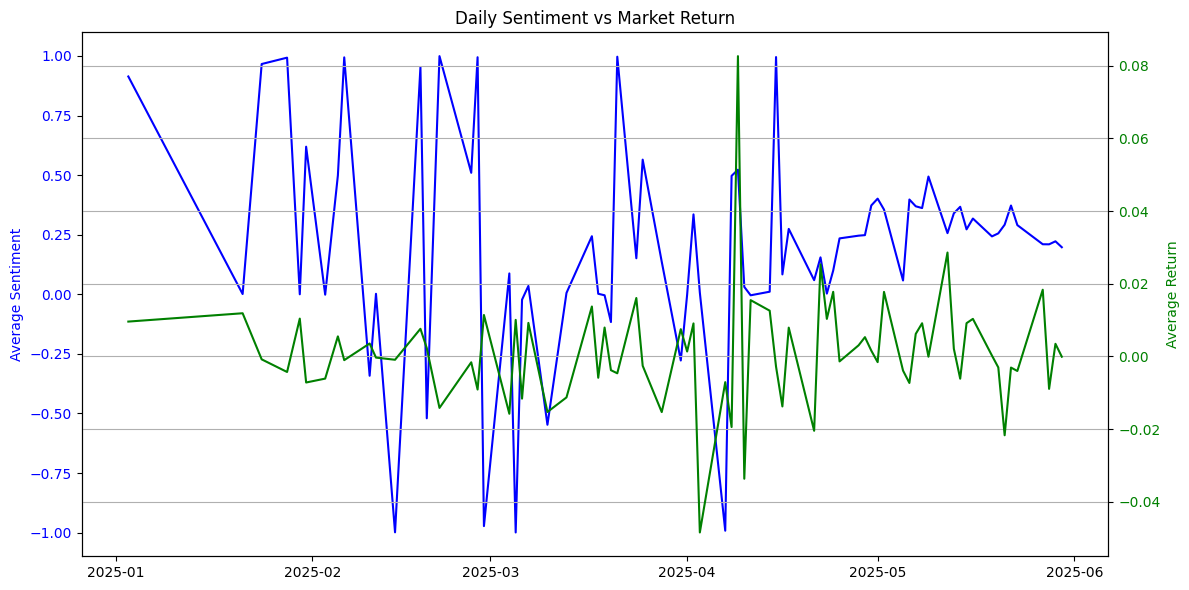

In [27]:
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.plot(merged_df['DATE'], merged_df['AVG_SENTIMENT'], color='blue', label='Avg Sentiment')
ax1.set_ylabel('Average Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(merged_df['DATE'], merged_df['AVG_RETURN'], color='green', label='Avg Market Return')
ax2.set_ylabel('Average Return', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Daily Sentiment vs Market Return')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [28]:
# CODE HERE
# Use as many coding cells as you need

portfolio_df = merged_df.copy()
initial_value = 1.0
portfolio_df['Portfolio_Value'] = (1 + portfolio_df['AVG_RETURN']).cumprod() * initial_value
portfolio_df[['DATE', 'AVG_RETURN', 'Portfolio_Value']]

,DATE,AVG_RETURN,Portfolio_Value
0,2025-01-03,0.009577,1.009577
1,2025-01-21,0.011869,1.021559
2,2025-01-24,-0.000823,1.020718
3,2025-01-28,-0.004301,1.016329
4,2025-01-30,0.010389,1.026888
...,...,...,...
69,2025-05-23,-0.004027,1.065410
70,2025-05-27,0.018349,1.084959
71,2025-05-28,-0.008950,1.075248
72,2025-05-29,0.003458,1.078966


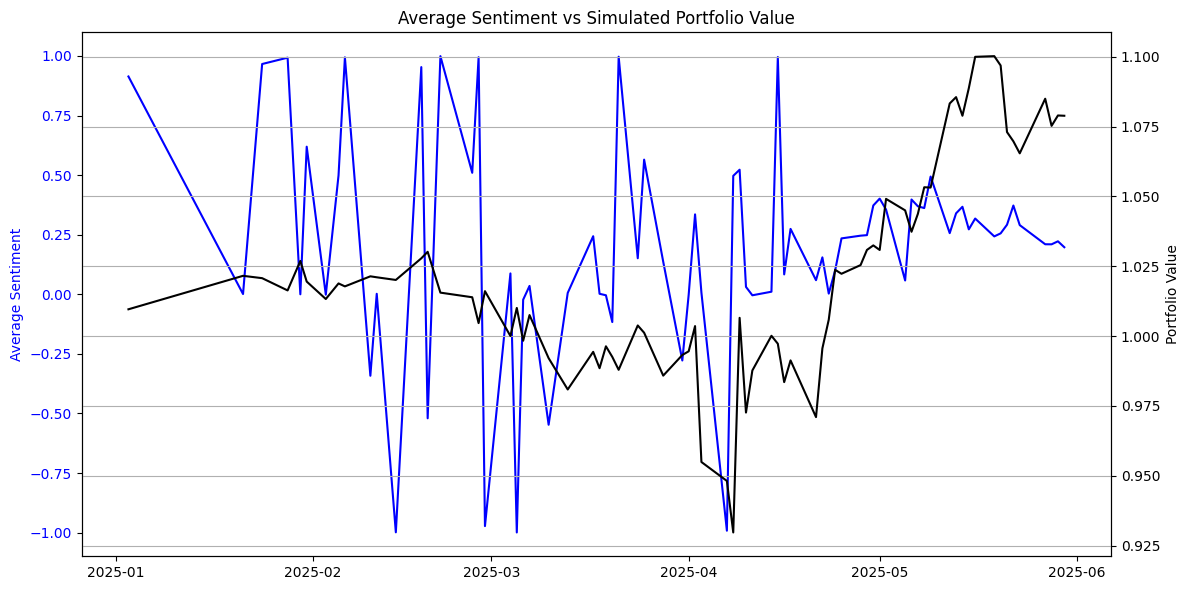

In [29]:
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.plot(portfolio_df['DATE'], portfolio_df['AVG_SENTIMENT'], color='blue', label='Avg Sentiment')
ax1.set_ylabel('Average Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(portfolio_df['DATE'], portfolio_df['Portfolio_Value'], color='black', label='Portfolio Value')
ax2.set_ylabel('Portfolio Value', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Average Sentiment vs Simulated Portfolio Value')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [30]:
# CODE HERE
# Use as many coding cells as you need

df_news_sector = pd.merge(df_news, df_meta[['TICKER', 'SECTOR']], on='TICKER', how='left')
df_news_sector['PUBLICATION_DATE'] = pd.to_datetime(df_news_sector['PUBLICATION_DATE'])
df_news_sector['MONTH'] = df_news_sector['PUBLICATION_DATE'].dt.month
df_news_sector['YEAR'] = df_news_sector['PUBLICATION_DATE'].dt.year

In [31]:
sentiment_monthly = (
    df_news_sector[
        (df_news_sector['YEAR'] == 2025) &
        (df_news_sector['MONTH'].between(2, 5))
    ]
    .groupby(['SECTOR', 'MONTH'])['SENTIMENT']
    .mean()
    .reset_index()
)

In [32]:
may_sentiment = sentiment_monthly[sentiment_monthly['MONTH'] == 5][['SECTOR', 'SENTIMENT']]
may_sentiment.columns = ['SECTOR', 'MAY_SENTIMENT']

In [33]:
may_prices = price_data.loc['2025-05']

may_returns = (may_prices.iloc[-1] - may_prices.iloc[0]) / may_prices.iloc[0]
may_returns = may_returns.reset_index()
may_returns.columns = ['TICKER', 'MAY_RETURN']

may_returns = pd.merge(may_returns, df_meta[['TICKER', 'SECTOR']], on='TICKER', how='left')
may_returns_sector = may_returns.groupby('SECTOR')['MAY_RETURN'].mean().reset_index()

In [34]:
sector_comparison = pd.merge(may_sentiment, may_returns_sector, on='SECTOR', how='inner')
display(sector_comparison)

,SECTOR,MAY_SENTIMENT,MAY_RETURN
0,Basic Materials,0.356129,0.029603
1,Communication Services,0.265364,0.042458
2,Consumer Cyclical,0.194967,0.057649
3,Consumer Defensive,0.141063,0.012911
4,Energy,0.217241,0.023249
5,Financial Services,0.259386,0.063157
6,Healthcare,0.285029,0.013455
7,Industrials,0.250161,0.070038
8,Real Estate,0.462404,0.004246
9,Technology,0.302090,0.074230


In [36]:
correlation = sector_comparison[['MAY_SENTIMENT', 'MAY_RETURN']].corr()
print(correlation)

               MAY_SENTIMENT  MAY_RETURN
MAY_SENTIMENT       1.000000   -0.260413
MAY_RETURN         -0.260413    1.000000


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


YOUR WRITTEN RESPONSE HERE

Sectors like Real Estate, Utilities and Basic Materials had the highest average sentiment in the news during May.

However, their performance was underwhelming:

- Real Estate return: 0.004246 (almost flat).
- Utilities return: 0.028714 (modest, below average).
- Basic Materials: 0.029603 (similar case to Utilties).

This suggests a disconnect between optimistic news coverage and actual financial performance.


### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


YOUR WRITTEN RESPONSE HERE

Sectors of Technology and Consumer Cyclical:

- Technology: 0.302090 (moderate) | 0.074230

- Consumer Cyclical: 0.194967 (relatively low) | 0.057649

These sectors performed well despite not having standout sentiment scores, implying that good returns don't always require positive news sentiment.

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

YOUR WRITTEN RESPONSE HERE

No, I would not invest based on sentiment alone, because sentiment can provide useful insights into market perception, the correlation in this case is actually negative (-0.26). This suggests that high sentiment did not correspond to higher returns. Also, sentiment is susceptible to Media hype, which can be confusing for the analysis.

It should be used as a complementary signal, not the sole basis for investment.

### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

YOUR WRITTEN RESPONSE HERE

Using rolling windows to smooth volatility can help produce more accurate plots, as seen earlier in the notebook where the sentiment analysis lines showed drastic fluctuations that did not reflect the true underlying trend. Additionally, applying lagged correlation analysis can help assess the predictive power of sentiment, while filtering by news volume helps reduce noise from low-coverage days.